In [43]:
# Import libraries and load dataset

# Data manipulation and preprocessing
import pandas as pd  # For reading and processing the dataset
import numpy as np   # For numerical operations and array handling

# Visualization
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns            # For enhanced visual styling

# Graph-based modeling
import networkx as nx  # For building and analyzing network graphs

# Machine learning and clustering
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# -----------------------------------------------
# Load the CSV file into a DataFrame
# Ensure the file is in the same directory as your notebook
# -----------------------------------------------

df = pd.read_csv("Cybersecurity Threat Landscape.csv")
print("Dataset succesfully loaded")

Dataset succesfully loaded


In [44]:
# Preview the first few rows to confirm successful import
df.head()

,Current_Role,Experience_Years,Employment_Sector,Uses_TI_Platforms,TI_Platforms_Used,Observed_Coordination,Repeat_Victimization_Score,Exploited_Relationships,Victim_Profile_Targeting_Score,Influential_Actors,Observed_Clusters,Community_Indicators,Community_Visibility_Score,Uses_Network_Mapping,Network_Model_Effectiveness,Useful_Network_Features,Network_Insights_Proactive_Defense
0,Security Analyst,3–5 years,Finance,Yes,"MISP, IBM X-Force",Yes,4,"Vendor-client, Supply chain",5,"Nation-state actors, Cybercriminal groups, Mal...",Yes,"Shared IP addresses, Coordinated timing, Commo...",4,Yes,Slightly more effective,"Betweenness centrality, Clustering coefficient",Yes
1,Security Analyst,0–2 years,Finance,Yes,IBM X-Force,Yes,4,"Vendor-client, Supply chain",4,"Nation-state actors, Cybercriminal groups",Yes,"Shared IP addresses, Common infrastructure",4,Yes,Slightly more effective,Degree centrality,Yes
2,Network Engineer,3–5 years,Finance,Yes,"IBM X-Force, Crowdstrike Falcon",Yes,5,"Vendor-client, Insider connections",5,"Nation-state actors, Cybercriminal groups, Ins...",Yes,"Shared IP addresses, Coordinated timing, Commo...",5,Yes,Much more effective,"Degree centrality, Clustering coefficient",Yes
3,CISO / Security Manager,6–10 years,Healthcare,Yes,"MISP, IBM X-Force",Yes,4,"Vendor-client, Peer-to-peer, Supply chain",4,"Nation-state actors, Cybercriminal groups, Mal...",Yes,"Coordinated timing, Common infrastructure",4,Yes,Much more effective,"Degree centrality, Edge density",Yes
4,Researcher / Academic,6–10 years,Technology,Yes,"IBM X-Force, Anomali",Yes,5,"Vendor-client, Insider connections",4,"Cybercriminal groups, Hacktivists",Yes,"Shared IP addresses, Similar payloads",5,Yes,Slightly more effective,"Degree centrality, Edge density",Yes


In [45]:
# Clean and Encode Multi-Select Fields

# Define the list of multi-select columns to process
multi_select_columns = [
    'TI_Platforms_Used',
    'Exploited_Relationships',
    'Influential_Actors',
    'Community_Indicators',
    'Useful_Network_Features'
]

# Create a dictionary to store encoded DataFrames for each column
encoded_columns = {}

# Iterate through each multi-select column
for column in multi_select_columns:
    
    # Fill missing values with empty strings to avoid errors during splitting
    df[column] = df[column].fillna('')
    
    # Split comma-separated strings into lists and strip whitespace
    df[column] = df[column].apply(lambda x: [item.strip() for item in x.split(',') if item.strip()])
    
    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    
    # Fit and transform the column
    encoded_df = pd.DataFrame(mlb.fit_transform(df[column]), columns=[f"{column}_{label}" for label in mlb.classes_])
    
    # Store the encoded DataFrame for reference
    encoded_columns[column] = encoded_df
    
    # Concatenate the encoded columns back into the main DataFrame
    df = pd.concat([df, encoded_df], axis=1)

# Confirm completion
print("Multi-select fields have been successfully encoded and integrated.")


Multi-select fields have been successfully encoded and integrated.


Graph: Exploited Relationships
Number of nodes: 4
Number of edges: 6


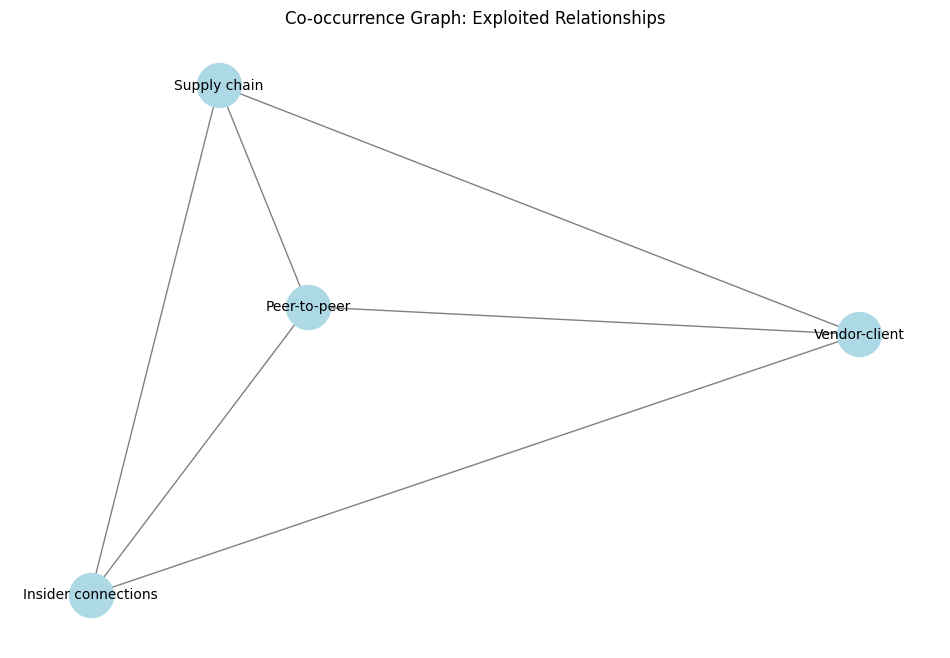

In [53]:
# ------------------------------------------------------
# Co-occurrence Graph for Exploited Relationships
# ------------------------------------------------------

import networkx as nx
import matplotlib.pyplot as plt

# Extract encoded binary matrix for Exploited Relationships
relationship_df = encoded_columns['Exploited_Relationships']

# Initialize graph
G_relationships = nx.Graph()

# Clean labels (strip prefix)
relationship_labels = [col.replace("Exploited_Relationships_", "") for col in relationship_df.columns]

# Build edges based on co-occurrence across respondents
for _, row in relationship_df.iterrows():
    selected = [relationship_labels[i] for i, val in enumerate(row) if val == 1]
    for i in range(len(selected)):
        for j in range(i + 1, len(selected)):
            if G_relationships.has_edge(selected[i], selected[j]):
                G_relationships[selected[i]][selected[j]]['weight'] += 1
            else:
                G_relationships.add_edge(selected[i], selected[j], weight=1)

# Print graph summary
print("Graph: Exploited Relationships")
print(f"Number of nodes: {G_relationships.number_of_nodes()}")
print(f"Number of edges: {G_relationships.number_of_edges()}")

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_relationships, seed=42)
nx.draw_networkx(G_relationships, pos, with_labels=True,
                 node_color='lightblue', edge_color='gray',
                 node_size=1000, font_size=10)
plt.title("Co-occurrence Graph: Exploited Relationships")
plt.axis('off')
plt.show()


Graph: Influential Actors
Number of nodes: 5
Number of edges: 10

Graph: Community Indicators
Number of nodes: 4
Number of edges: 6

Graph: Useful Network Features
Number of nodes: 4
Number of edges: 6


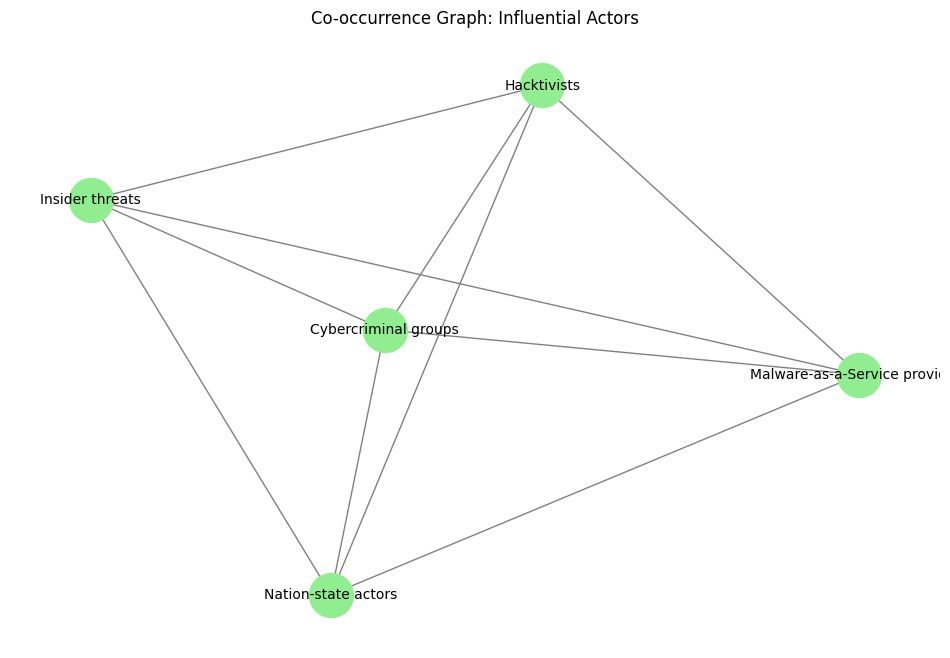

In [47]:
# Co-occurrence Graph for Influential Actors

def build_clean_cooccurrence_graph(encoded_df, title, prefix_to_strip=None):
    """
    Constructs a co-occurrence graph from a binary matrix.
    Nodes represent entities (e.g., actors, indicators).
    Edges represent co-occurrence across respondents.
    """
    G = nx.Graph()
    entities = encoded_df.columns

    # Map original column names to clean labels
    label_map = {}
    for col in entities:
        if prefix_to_strip and col.startswith(prefix_to_strip + "_"):
            label_map[col] = col.replace(prefix_to_strip + "_", "")
        else:
            label_map[col] = col

    # Build graph edges based on co-occurrence
    for _, row in encoded_df.iterrows():
        selected = [label_map[entity] for entity in entities if row[entity] == 1]
        for i in range(len(selected)):
            for j in range(i + 1, len(selected)):
                if G.has_edge(selected[i], selected[j]):
                    G[selected[i]][selected[j]]['weight'] += 1
                else:
                    G.add_edge(selected[i], selected[j], weight=1)

    print(f"\nGraph: {title}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    return G

# Build graphs with cleaned labels
G_actors = build_clean_cooccurrence_graph(encoded_columns['Influential_Actors'], "Influential Actors", prefix_to_strip="Influential_Actors")
G_indicators = build_clean_cooccurrence_graph(encoded_columns['Community_Indicators'], "Community Indicators", prefix_to_strip="Community_Indicators")
G_features = build_clean_cooccurrence_graph(encoded_columns['Useful_Network_Features'], "Useful Network Features", prefix_to_strip="Useful_Network_Features")

# Visualize one graph (e.g., Influential Actors)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_actors, seed=42)
nx.draw_networkx(G_actors, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=1000, font_size=10)
plt.title("Co-occurrence Graph: Influential Actors")
plt.axis('off')
plt.show()



Graph: Community Indicators
Number of nodes: 4
Number of edges: 6


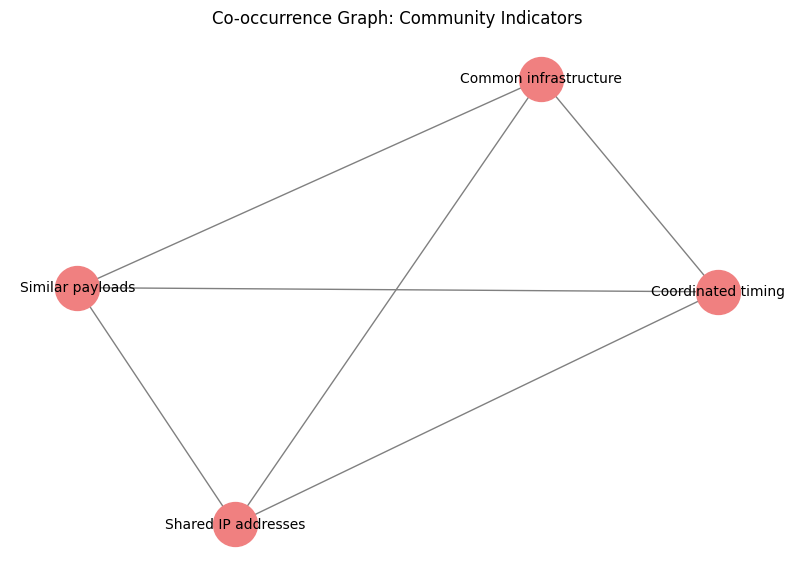

In [48]:
# Co-occurrence Graph for Community Indicators

def build_clean_cooccurrence_graph(encoded_df, title, prefix_to_strip=None):
    """
    Constructs a co-occurrence graph from a binary matrix.
    Nodes represent entities (e.g., indicators).
    Edges represent co-occurrence across respondents.
    """
    G = nx.Graph()
    entities = encoded_df.columns

    # Map original column names to clean labels
    label_map = {}
    for col in entities:
        if prefix_to_strip and col.startswith(prefix_to_strip + "_"):
            label_map[col] = col.replace(prefix_to_strip + "_", "")
        else:
            label_map[col] = col

    # Build graph edges based on co-occurrence
    for _, row in encoded_df.iterrows():
        selected = [label_map[entity] for entity in entities if row[entity] == 1]
        for i in range(len(selected)):
            for j in range(i + 1, len(selected)):
                if G.has_edge(selected[i], selected[j]):
                    G[selected[i]][selected[j]]['weight'] += 1
                else:
                    G.add_edge(selected[i], selected[j], weight=1)

    print(f"\nGraph: {title}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    return G

# Build and visualize the graph for Community Indicators
G_indicators_clean = build_clean_cooccurrence_graph(
    encoded_columns['Community_Indicators'],
    title="Community Indicators",
    prefix_to_strip="Community_Indicators"
)

# Visualize the graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_indicators_clean, seed=42)
nx.draw_networkx(G_indicators_clean, pos, with_labels=True,
                 node_color='lightcoral', edge_color='gray',
                 node_size=1000, font_size=10)
plt.title("Co-occurrence Graph: Community Indicators")
plt.axis('off')
plt.show()


Graph: Useful Network Features
Number of nodes: 4
Number of edges: 6


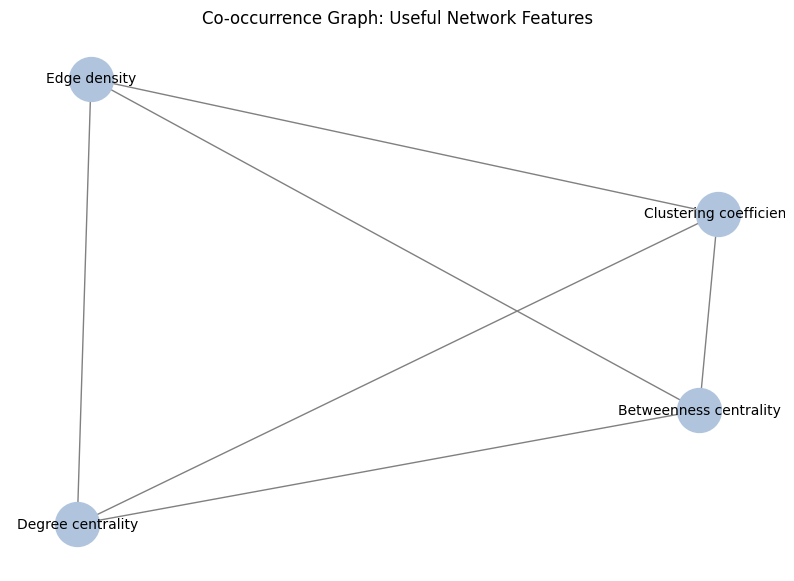

In [49]:
# Co-occurrence Graph for Useful Network Features

def build_clean_cooccurrence_graph(encoded_df, title, prefix_to_strip=None):
    """
    Constructs a co-occurrence graph from a binary matrix.
    Nodes represent entities (e.g., network features).
    Edges represent co-occurrence across respondents.
    Optionally strips prefix from node labels for cleaner visualization.
    """
    G = nx.Graph()
    entities = encoded_df.columns

    # Map original column names to clean labels
    label_map = {}
    for col in entities:
        if prefix_to_strip and col.startswith(prefix_to_strip + "_"):
            label_map[col] = col.replace(prefix_to_strip + "_", "")
        else:
            label_map[col] = col

    # Build graph edges based on co-occurrence
    for _, row in encoded_df.iterrows():
        selected = [label_map[entity] for entity in entities if row[entity] == 1]
        for i in range(len(selected)):
            for j in range(i + 1, len(selected)):
                if G.has_edge(selected[i], selected[j]):
                    G[selected[i]][selected[j]]['weight'] += 1
                else:
                    G.add_edge(selected[i], selected[j], weight=1)

    print(f"\nGraph: {title}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    return G

# Build and visualize the graph for Useful Network Features
G_features_clean = build_clean_cooccurrence_graph(
    encoded_columns['Useful_Network_Features'],
    title="Useful Network Features",
    prefix_to_strip="Useful_Network_Features"
)

# Visualize the graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_features_clean, seed=42)
nx.draw_networkx(G_features_clean, pos, with_labels=True,
                 node_color='lightsteelblue', edge_color='gray',
                 node_size=1000, font_size=10)
plt.title("Co-occurrence Graph: Useful Network Features")
plt.axis('off')
plt.show()


Graph: Exploited Relationships
Detected 1 communities.


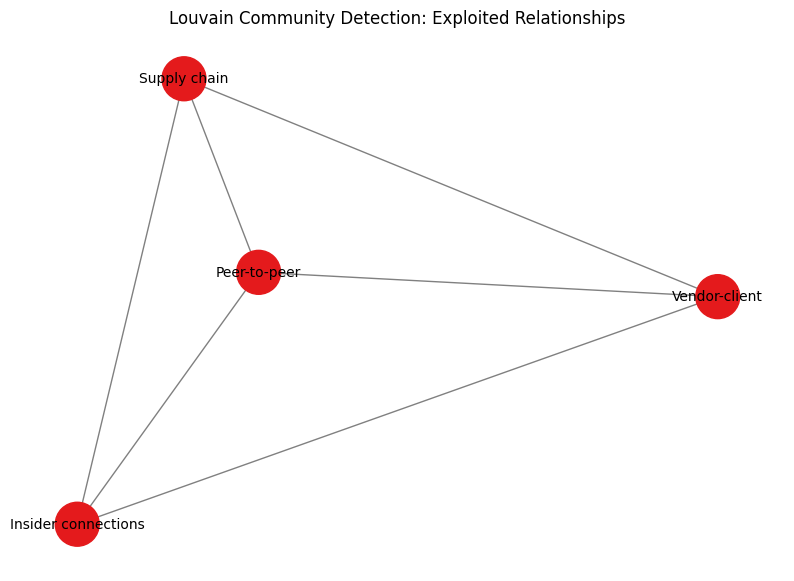


Graph: Influential Actors
Detected 1 communities.


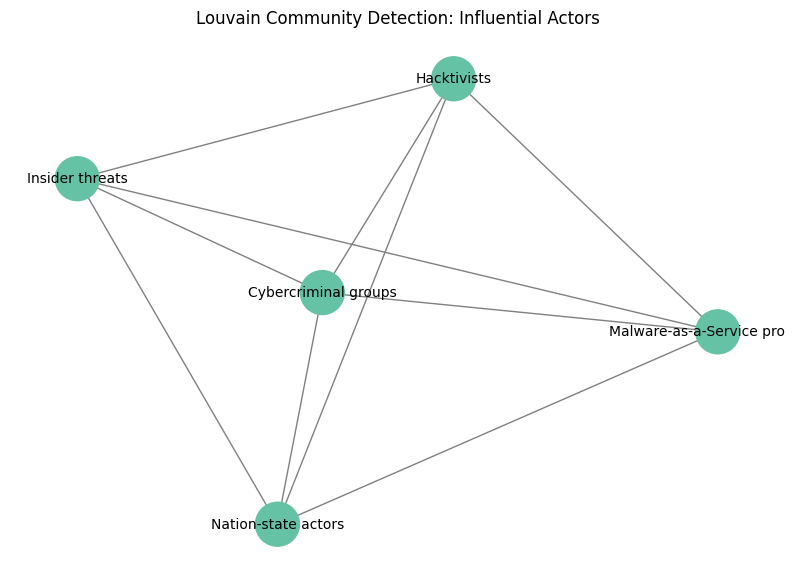


Graph: Community Indicators
Detected 1 communities.


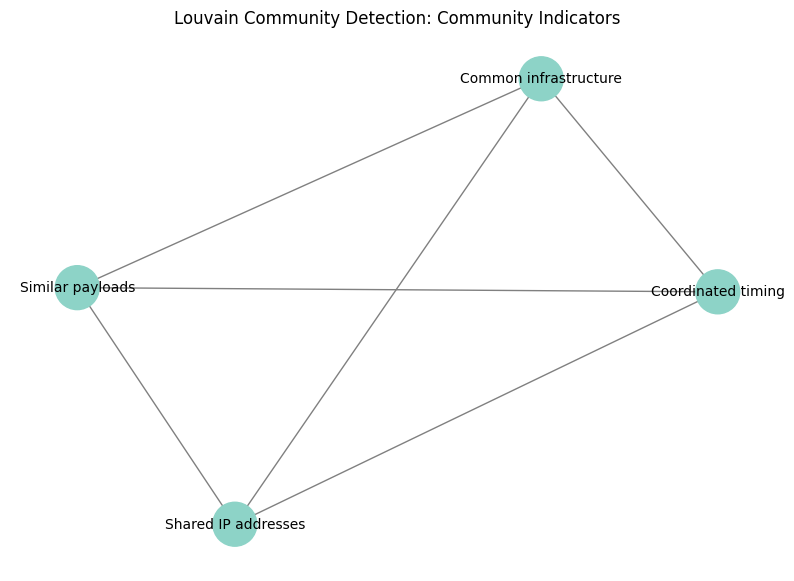


Graph: Useful Network Features
Detected 1 communities.


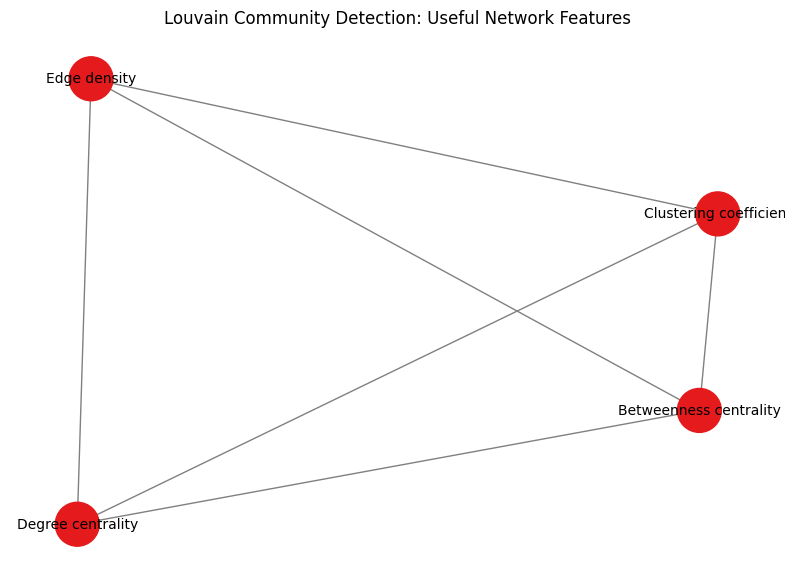

In [50]:
# Apply Louvain Community Detection

import community as community_louvain

# Dictionary of graphs with titles and optional color maps
graph_dict = {
    "Exploited Relationships": (G_relationships, plt.cm.Set1),
    "Influential Actors": (G_actors, plt.cm.Set2),
    "Community Indicators": (G_indicators_clean, plt.cm.Set3),
    "Useful Network Features": (G_features_clean, plt.cm.Set1)
}

# Loop through each graph and apply Louvain community detection
for title, (G, cmap) in graph_dict.items():
    # Apply Louvain algorithm
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    # Extract community labels
    communities = set(partition.values())
    print(f"\nGraph: {title}")
    print(f"Detected {len(communities)} communities.")

    # Visualize with community coloring
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    colors = [partition[node] for node in G.nodes()]
    nx.draw_networkx(G, pos, node_color=colors, with_labels=True,
                     edge_color='gray', node_size=1000, font_size=10,
                     cmap=cmap)
    plt.title(f"Louvain Community Detection: {title}")
    plt.axis('off')
    plt.show()


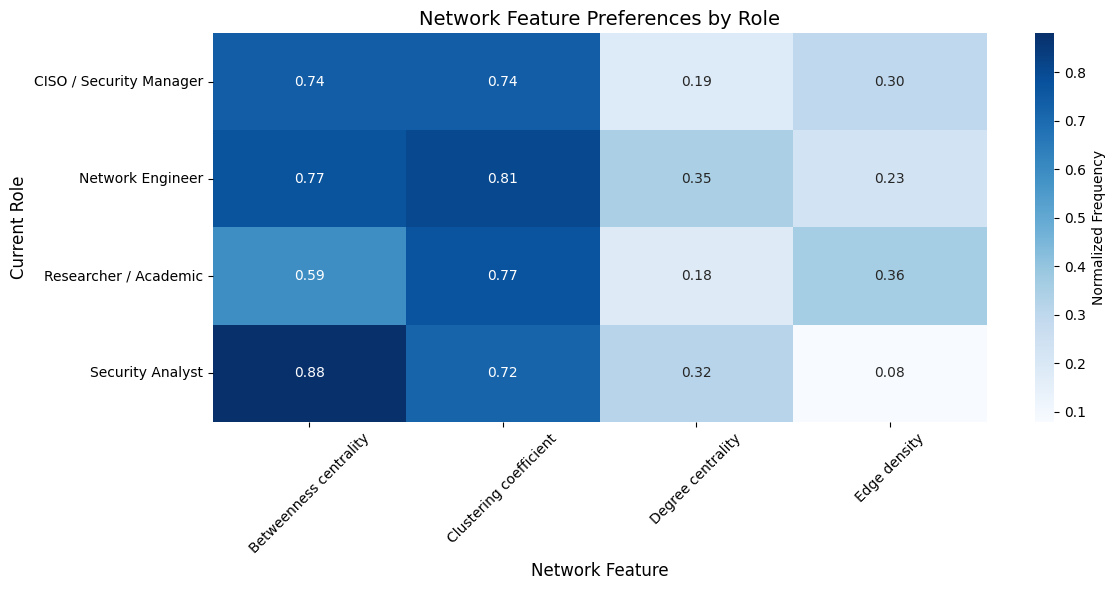

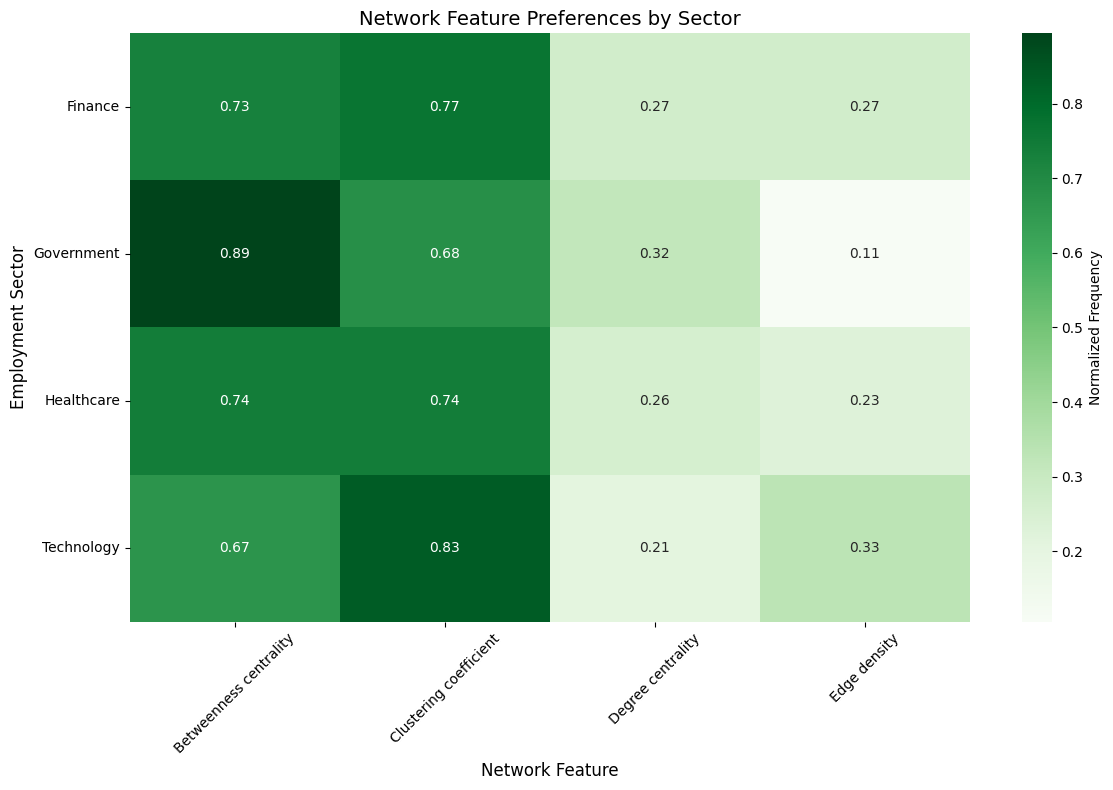

In [51]:
# Analyze Centrality Preferences

# Strip prefix from feature column labels
clean_feature_columns = [col.replace("Useful_Network_Features_", "") for col in encoded_columns['Useful_Network_Features'].columns]

# Create a copy of the encoded feature matrix with clean labels
features_clean_df = encoded_columns['Useful_Network_Features'].copy()
features_clean_df.columns = clean_feature_columns

# Concatenate clean features back to main DataFrame
df_features_clean = pd.concat([df[['Current_Role', 'Employment_Sector']], features_clean_df], axis=1)

# -------------------------------
# Role-Level Analysis
# -------------------------------
role_feature_matrix = df_features_clean.groupby('Current_Role')[clean_feature_columns].sum()
role_counts = df_features_clean['Current_Role'].value_counts()
role_feature_matrix = role_feature_matrix.div(role_counts, axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(role_feature_matrix, annot=True, cmap='Blues', fmt=".2f",
            cbar_kws={'label': 'Normalized Frequency'})
plt.title("Network Feature Preferences by Role", fontsize=14)
plt.ylabel("Current Role", fontsize=12)
plt.xlabel("Network Feature", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# -------------------------------
# Sector-Level Analysis
# -------------------------------
sector_feature_matrix = df_features_clean.groupby('Employment_Sector')[clean_feature_columns].sum()
sector_counts = df_features_clean['Employment_Sector'].value_counts()
sector_feature_matrix = sector_feature_matrix.div(sector_counts, axis=0)

plt.figure(figsize=(12, 8))  # Increased height for better label spacing
sns.heatmap(sector_feature_matrix, annot=True, cmap='Greens', fmt=".2f",
            cbar_kws={'label': 'Normalized Frequency'})
plt.title("Network Feature Preferences by Sector", fontsize=14)
plt.ylabel("Employment Sector", fontsize=12)
plt.xlabel("Network Feature", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Explicitly set y-axis labels to ensure visibility
plt.gca().set_yticklabels(sector_feature_matrix.index, rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

In [52]:
# Correlate Visibility and Action

from scipy.stats import spearmanr, chi2_contingency

# Encode binary target variable
df['Defense_Action_Binary'] = df['Network_Insights_Proactive_Defense'].map({'Yes': 1, 'No': 0})

# Encode Network_Model_Effectiveness ordinally
effectiveness_map = {
    'Not effective': 1,
    'Slightly more effective': 2,
    'Much more effective': 3
}
df['Model_Effectiveness_Score'] = df['Network_Model_Effectiveness'].map(effectiveness_map)

# Spearman correlation: Visibility Score vs Defense Action
spearman_vis, p_vis = spearmanr(df['Community_Visibility_Score'], df['Defense_Action_Binary'])
print(f"Spearman Correlation (Visibility ↔ Defense Action): {spearman_vis:.3f}, p-value: {p_vis:.4f}")

# Spearman correlation: Model Effectiveness vs Defense Action
spearman_eff, p_eff = spearmanr(df['Model_Effectiveness_Score'], df['Defense_Action_Binary'])
print(f"Spearman Correlation (Effectiveness ↔ Defense Action): {spearman_eff:.3f}, p-value: {p_eff:.4f}")

# Chi-square test: Model Effectiveness vs Defense Action
contingency_table = pd.crosstab(df['Network_Model_Effectiveness'], df['Network_Insights_Proactive_Defense'])
chi2, p_chi, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square Test (Effectiveness ↔ Defense Action): χ² = {chi2:.2f}, p-value = {p_chi:.4f}")


Spearman Correlation (Visibility ↔ Defense Action): 0.307, p-value: 0.0019
Spearman Correlation (Effectiveness ↔ Defense Action): nan, p-value: nan
Chi-square Test (Effectiveness ↔ Defense Action): χ² = 28.69, p-value = 0.0000
